# Section 5.2: Partial sensitivity modelling in (DP-)SGD

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from deuterium import Variable, to_vec, random_symbols
import symengine as se
from sklearn.metrics import accuracy_score
import sys
sys.setrecursionlimit(1_000_000)
import warnings
warnings.filterwarnings("ignore")

Define some utility functions, notably the loss functions and tempered sigmoid activation functions.

In [34]:
to_data = np.vectorize(lambda x: x.data)

def sigmoid(x, s=1, T=1, o=0):
        return (s/(1+np.exp(-T*x)))-o

def tanh(x):
    return sigmoid(x, 2, 2, 1)

bce_loss = lambda y_pred, y_true: -np.mean(np.multiply(y_true, np.log(y_pred)) + np.multiply((1 - y_true), np.log(1 - y_pred)))
normalize = lambda x: (x-x.min())/(x.max()-x.min())

Define the network architecture

In [35]:
IN=25
INTERMEDIATE= 8

In [36]:
x = to_vec(np.array(random_symbols(IN, "x")).reshape((1,IN))) 
y = to_vec(np.array(random_symbols(1, "y")))

w1 = to_vec(np.array(random_symbols(IN*INTERMEDIATE, "w1")).reshape(IN, INTERMEDIATE))
b = to_vec(np.array(random_symbols(INTERMEDIATE, "b")).reshape(1, INTERMEDIATE))
w2 = to_vec(np.array(random_symbols(INTERMEDIATE, "w2")).reshape(INTERMEDIATE,1))

In [37]:
all_symbols = [symb for symb in np.concatenate((x.flatten(), y.flatten(), w1.flatten(), b.flatten(), w2.flatten()))]

Symbolically calculate the network output

In [38]:
layer_1 = sigmoid(x@w1)+b
y_pred = sigmoid(layer_1@w2)
loss = bce_loss(y_pred, y)

Obtain the gradients w.r.t all inputs

In [39]:
loss.backward()

In [40]:
x_grad = np.array([i.grad for i in x.flatten().tolist()])
y_grad = np.array([i.grad for i in y.flatten().tolist()])
w1_grad = np.array([i.grad for i in w1.flatten().tolist()])
b_grad = np.array([i.grad for i in b.flatten().tolist()])
w2_grad = np.array([i.grad for i in w2.flatten().tolist()])

full_grad = to_vec(np.concatenate((x_grad, y_grad, w1_grad, b_grad, w2_grad)))

Obtain the sensitivity term

In [41]:
norm = np.linalg.norm(full_grad, ord=2)

Differentiate the sensitivity w.r.t the inputs to obtain the partial sensitivities.

In [42]:
norm.backward()

In [43]:
N = [i.grad for i in full_grad.flatten().tolist()]

Pre-compile all relevant functions to train using substitution later.

In [44]:
y_pred_func = se.Lambdify(to_data([symb for symb in np.concatenate((x.flatten(), w1.flatten(), b.flatten(), w2.flatten()))]), to_data(y_pred), cse=True) # output of net
loss_func = se.Lambdify(to_data(all_symbols), to_data(loss), cse=True) #loss
grad_func = se.Lambdify(to_data(all_symbols), (np.concatenate((w1_grad.flatten(), b_grad.flatten(), w2_grad.flatten()))), cse=True) # gradient w.r.t w+b only
grad_norm = se.Lambdify(to_data(all_symbols), norm.data, cse=True) #gradient norm
partial_sens = se.Lambdify(to_data(all_symbols), N, cse=True) #partial sensitivities

The next functions generate synthetic data of vertical and horizontal bars with Gaussian noise.

In [45]:
def get_vertical(n=100, train=True):
    out = []
    vertical = np.array([[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],[0,0,1,0,0],]).astype(np.float64).flatten()
    for _ in range(n):
        ar = vertical + np.random.normal(0, 0.2, size=vertical.shape)
        ar = normalize(ar)
        if train:
            out.append(np.concatenate((ar, [0.])))    
        else:
            out.append(ar)
    return np.array(out)

def get_horizontal(n=100, train=True):
    out = []
    vertical = np.array([[0,0,0,0,0],[0,0,0,0,0],[1,1,1,1,1],[0,0,0,0,0],[0,0,0,0,0],]).astype(np.float64).flatten()
    for _ in range(n):
        ar = vertical + np.random.normal(0, 0.2, size=vertical.shape)
        ar = normalize(ar)
        if train:
            out.append(np.concatenate((ar, [1.])))
        else:
            out.append(ar)
    return np.array(out)

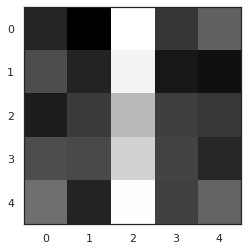

In [46]:
plt.imshow(get_vertical(1, False).reshape((5,5)), cmap="gray")

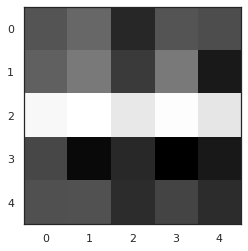

In [47]:
plt.imshow(get_horizontal(1, False).reshape((5,5)), cmap="gray")

We now train the network by substituting concrete values. Weights are initialised from a uniform distribution.

In [48]:
LR = 0.1

HOW_MANY = 1000

vertical = get_vertical(HOW_MANY)
horizontal = get_horizontal(HOW_MANY)

weights = np.random.uniform(-1., 1., len(np.concatenate((w1.flatten(), b.flatten(), w2.flatten()))))[None, ...]
vert_batch = np.hstack((vertical, np.tile(weights, (HOW_MANY, 1))))
horiz_batch = np.hstack((horizontal, np.tile(weights, (HOW_MANY, 1))))

for i in range(1000):
    if i%100 ==0: print(loss_func(np.vstack((vert_batch, horiz_batch))).mean())
    G = grad_func(np.vstack((vert_batch,horiz_batch))).mean(axis=0)
    weights = weights - (G*LR)
    vert_batch = np.hstack((vertical, np.tile(weights, (HOW_MANY, 1))))
    horiz_batch = np.hstack((horizontal, np.tile(weights, (HOW_MANY, 1))))

1.3163334492187284
0.4364210458878441
0.21036076421643174
0.11035220409938791
0.0692648402252857
0.04887789111931295
0.0371368815334255
0.029647940487495188
0.024514055376021054
0.020802942384915975


We generate test images to test network performance

In [49]:
vert_test = np.hstack((get_vertical(100, train=False), np.tile(weights, (100, 1))))
horiz_test = np.hstack((get_horizontal(100, train=False), np.tile(weights, (100, 1))))

Obtain the accuracy score on the test set

In [20]:
accuracy_score(np.where(y_pred_func(np.vstack((vert_test,horiz_test))).squeeze()>0.5, 1, 0), np.concatenate((np.zeros(100), np.ones(100))))

1.0

Calculate the partial sensitivites of the input pixels (first 25 inputs)

In [21]:
vertical_privacy_loss = partial_sens(vert_batch)[:,:25].reshape(1000, 5,5)
horizontal_privacy_loss = partial_sens(horiz_batch)[:,:25].reshape(1000, 5, 5)

Code for reproducing the paper figure.

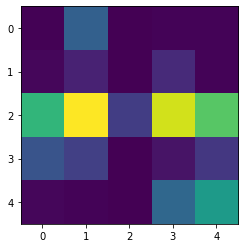

In [22]:
plt.imshow(vertical_privacy_loss.max(0), cmap="viridis")

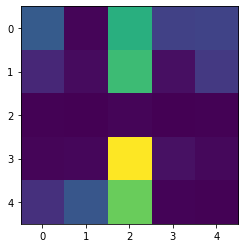

In [23]:
plt.imshow(horizontal_privacy_loss.max(0), cmap="viridis")

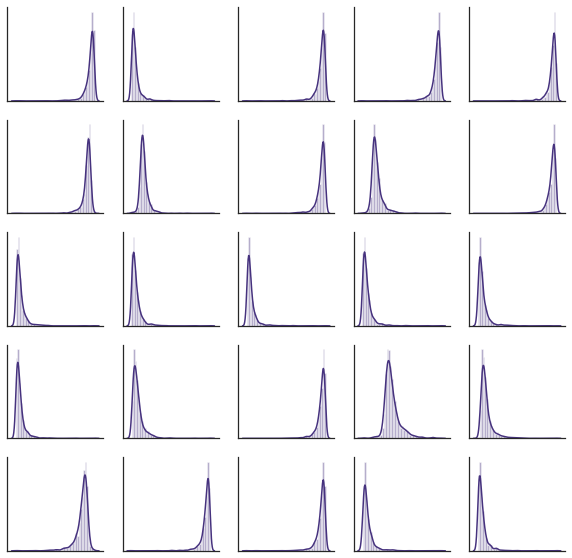

In [24]:
sns.set(palette="viridis", style="white")
fig, ax = plt.subplots(5,5, figsize=(10,10))
for i, axi in enumerate(ax.flat):
    sns.distplot(vertical_privacy_loss.reshape(1000,-1)[:,i], ax=axi, hist=True)
    axi.set_xticklabels(())
    axi.set_xticks(())
    axi.set_yticklabels(())
    axi.set_yticks(())
    axi.set_ylabel(None)
sns.despine()

The experiment is repeated using DP-SGD.

In [25]:
LR = 0.1
C = .1 #clipping value
M = 5. #noise multiplier

HOW_MANY = 1000

vertical = get_vertical(HOW_MANY)
horizontal = get_horizontal(HOW_MANY)

weights = np.random.uniform(-1., 1., len(np.concatenate((w1.flatten(), b.flatten(), w2.flatten()))))[None, ...]
vert_batch = np.hstack((vertical, np.tile(weights, (HOW_MANY, 1))))
horiz_batch = np.hstack((horizontal, np.tile(weights, (HOW_MANY, 1))))

for i in range(2000):
    if i%100 ==0: print(loss_func(np.vstack((vert_batch, horiz_batch))).mean())
    G = grad_func(np.vstack((vert_batch,horiz_batch))) # gradient values
    N = grad_norm(np.vstack((vert_batch,horiz_batch))) # gradient norm
    clip_coef = (np.maximum(1., N/C)**-1)[...,None] # clipping coefficient per Abadi et al.
    G_clipped = np.multiply(G, clip_coef) # obtain clipped gradient
    averaged = G_clipped.mean(axis=0) # average clipped gradients across batch axis
    G_noised =  averaged + np.random.normal(0, C*M, size=averaged.shape)/HOW_MANY #add appropriately scaled noise  
    weights = weights - (G_noised*LR)
    vert_batch = np.hstack((vertical, np.tile(weights, (HOW_MANY, 1))))
    horiz_batch = np.hstack((horizontal, np.tile(weights, (HOW_MANY, 1))))

0.7724371322620789
0.6087388183634743
0.5340825959355032
0.491821763161077
0.45951176292623497
0.43067271579950817
0.4037732280938373
0.37883942880425253
0.3554173483671054
0.3339382160149164
0.3140501683749795
0.29590610828502917
0.27938860872136567
0.2642326690841254
0.25038211025717266
0.23774687655876314
0.22606371628231145
0.21537530879281258
0.205559620945328
0.19647511415631935


In [26]:
vert_test = np.hstack((get_vertical(100, train=False), np.tile(weights, (100, 1))))
horiz_test = np.hstack((get_horizontal(100, train=False), np.tile(weights, (100, 1))))

The accuracy is identical to the non-private case

In [27]:
accuracy_score(np.where(y_pred_func(np.vstack((vert_test,horiz_test))).squeeze()>0.5, 1, 0), np.concatenate((np.zeros(100), np.ones(100))))

1.0

In [28]:
dp_vertical_privacy_loss = partial_sens(vert_batch)[:,:25].reshape(1000, 5,5)
dp_horizontal_privacy_loss = partial_sens(horiz_batch)[:,:25].reshape(1000, 5, 5)

Code to reproduce the DP-SGD part of the figure.

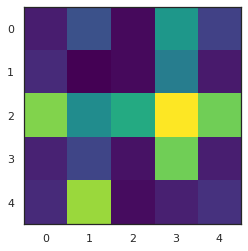

In [30]:
plt.imshow(dp_vertical_privacy_loss.max(0), cmap="viridis")

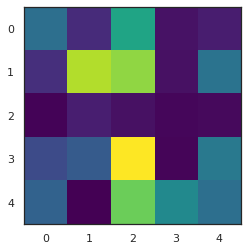

In [31]:
plt.imshow(dp_horizontal_privacy_loss.max(0), cmap="viridis")

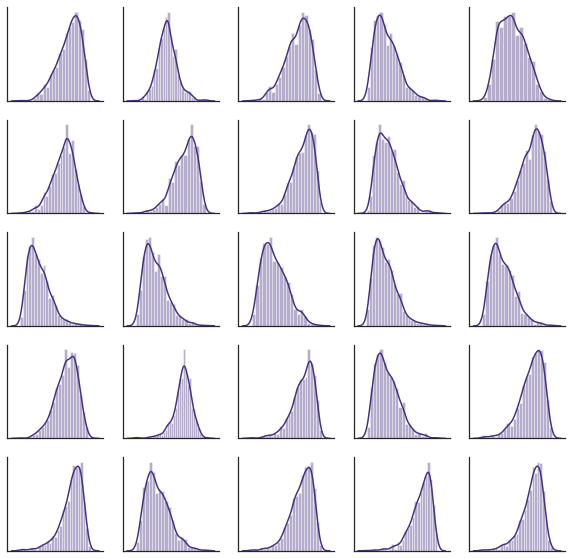

In [32]:
sns.set(palette="viridis", style="white")
fig, ax = plt.subplots(5,5, figsize=(10,10))
for i, axi in enumerate(ax.flat):
    sns.distplot(dp_vertical_privacy_loss.reshape(1000,-1)[:,i], ax=axi, hist=True)
    axi.set_xticklabels(())
    axi.set_xticks(())
    axi.set_yticklabels(())
    axi.set_yticks(())
    axi.set_ylabel(None)
sns.despine()